In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
import numpy as np
from PIL import Image
directory_train =  '../Suhyun/images2/ar3/birds/train'

directory_valid = '../Suhyun/images2/ar3/birds/valid'
directory_test = '../Suhyun/images2/ar3/birds/test'
train_dataset = train_datagen.flow_from_directory(batch_size=128,
                                                 directory = directory_train,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')


valid_dataset = train_datagen.flow_from_directory(batch_size=128,
                                                 directory = directory_valid,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

# for i in range(len(train_dataset)):
    
#     np.all(train_dataset[i][0])






Found 39365 images belonging to 275 classes.
Found 1376 images belonging to 275 classes.


# 285 Bird Species Multiclassification
40930 Train images, 1425 Test, 1425 Validation images from  https://www.kaggle.com/gpiosenka/100-bird-species

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 

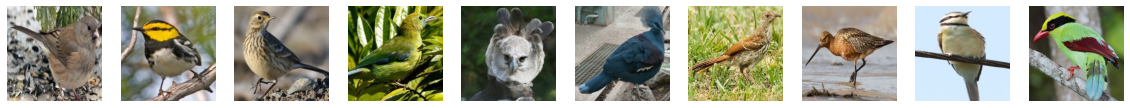

In [16]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=10,figsize=(20,20))
for i in range(10):
    ax[i].imshow(train_dataset[0][0][i+10])
    ax[i].axis('off')


In [17]:
def hard_swish(features):

  
  features = tf.convert_to_tensor(features)
  fdtype = features.dtype
  return features * tf.nn.relu6(features + tf.cast(3., fdtype)) * (1. / 6.)

In [7]:

def se_block(inputs, ch, ratio=16):

    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(ch//ratio, activation='relu')(x)
    y = tf.keras.layers.Dense(ch, activation='sigmoid')(x)
    y = tf.keras.layers.multiply([inputs, y])
    out = hard_swish(y)
    return out

In [8]:
def dep_bn(inputs, filter : int, kernel :int, stride: int):

  y = tf.keras.layers.Conv2D(filters = filter, kernel_size= kernel, strides= stride, padding= 'same')(inputs)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  out = tf.nn.relu6(bn)
  
  return out


def Inverted_residual_SEblock(x,  hs: bool, se: bool , filters, kernel, strides,  expansion_ratio ):


    #pointwise
    y = tf.keras.layers.Conv2D(filters = x.get_shape().as_list()[-1]*expansion_ratio, kernel_size=  1, strides = 1, padding= 'same')(x)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
    
    
    #depthwise
    y = tf.keras.layers.DepthwiseConv2D(kernel_size=  kernel, strides= strides, padding= 'same', depth_multiplier = 1)(y_p)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        out = hard_swish(bn)
    else:
        out = tf.nn.relu6(bn)
   
    
    if se: 
        channel = out.get_shape().as_list()[-1]
        out = se_block(out, channel)

    
    #pointwise
    y = tf.keras.layers.Conv2D(filters = filters, kernel_size=  1, strides = 1, padding= 'same')(out)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
        
        
    
    if strides == 1:
        if x.shape[3] != filters : 
           x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = strides, padding = "same")(x)
        out  = tf.keras.layers.Add()([x, y_p])
   
    

    return y


In [9]:
def create_mobilenetV3(inputs):

   x = dep_bn(inputs, 16, 3, 2)
   x = Inverted_residual_SEblock(x, False, False, 16, 3, 1,1)

   x = Inverted_residual_SEblock(x, False, False, 24, 3, 2, 4)
   x = Inverted_residual_SEblock(x, False, False, 24, 3, 1, 3)
   
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 2, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)

   x = Inverted_residual_SEblock(x, True, False, 80, 3, 2, 6)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 2.5)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
    
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
    
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 2, 6)
   
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = dep_bn(x, 960, 1, 1)
   
   t = tf.keras.layers.AveragePooling2D(1)(x)
   t = tf.keras.layers.Flatten()(t)
   outputs = tf.keras.layers.Dense(275, activation='softmax')(t)
   return outputs

In [10]:
inputs = tf.keras.Input(shape=(224,224,3))
outputs = create_mobilenetV3(inputs)
outputs.shape

TensorShape([None, 275])

In [11]:
inputs = tf.keras.Input(shape=(224,224,3))
outputs = create_mobilenetV3(inputs)

model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [12]:
model.fit(train_dataset, validation_data=valid_dataset, epochs = 50)

Epoch 1/50
308/308 [==============================] - 108s 335ms/step - loss: 6.0497 - accuracy: 0.0050 - val_loss: 5.6194 - val_accuracy: 0.0036
Epoch 2/50
308/308 [==============================] - 101s 329ms/step - loss: 5.6202 - accuracy: 0.0081 - val_loss: 5.6119 - val_accuracy: 0.0036
Epoch 3/50
308/308 [==============================] - 102s 329ms/step - loss: 5.5539 - accuracy: 0.0085 - val_loss: 6.1496 - val_accuracy: 0.0058
Epoch 4/50
308/308 [==============================] - 100s 325ms/step - loss: 5.5817 - accuracy: 0.0080 - val_loss: 44.8498 - val_accuracy: 0.0036
Epoch 5/50
308/308 [==============================] - 102s 331ms/step - loss: 5.3074 - accuracy: 0.0171 - val_loss: 30.0272 - val_accuracy: 0.0036
Epoch 6/50
308/308 [==============================] - 100s 326ms/step - loss: 4.9349 - accuracy: 0.0361 - val_loss: 14.6782 - val_accuracy: 0.0094
Epoch 7/50
308/308 [==============================] - 102s 330ms/step - loss: 4.7089 - accuracy: 0.0544 - val_loss: 9.429

In [13]:
predictions = model.predict(train_dataset[0][0])

In [14]:
def index_output(prediction) :
    
    index_list = []
    for pred in prediction:
        i = np.argmax(pred)
        index_list.append(i)
    return index_list

In [15]:
y_pred = np.array(index_output(predictions))
y_pred.shape

(128,)

In [16]:
Y_true =[]
for y in train_dataset[0][1]:
    Y_true.append(np.where(y==1))
Y_true = np.squeeze(np.asarray(Y_true))
Y_true.shape

(128,)

In [18]:

from sklearn.metrics import classification_report

print(classification_report(Y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         0
           2       0.33      1.00      0.50         1
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       1.00      1.00      1.00         1
          16       0.50      0.50      0.50         2
          17       0.50      1.00      0.67         1
          18       1.00      1.00      1.00         1
          19       1.00      0.50      0.67         2
          20       1.00      1.00      1.00         1
          23       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          32       0.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1